# Names Analysis & Modeling

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
import os
from collections import Counter

In [2]:
sys.path.append(os.path.abspath(".."))

from core.utils.data_loader import DataLoader
from core.utils.region_mapper import RegionMapper
from core.config.pipeline_config import PipelineConfig

from research.statistics.utils import LETTERS
from research.statistics.utils import identified_category_dist
from research.statistics.utils import explode_words_token
from research.statistics.utils import build_transition_probabilities
from research.statistics.utils import build_transition_comparisons
from research.statistics.utils import build_letter_frequencies
from research.statistics.plots import plot_transition_matrix

In [3]:
config = PipelineConfig(
    paths={
        "root_dir": "../data",
        "data_dir": "../data/dataset",
        "models_dir": "../models",
        "outputs_dir": "../data/processed",
        "logs_dir": "../logs",
        "configs_dir": "../configs",
        "checkpoints_dir": "../checkpoints"
    }
)

loader = DataLoader(config)

In [4]:
df = loader.load_csv_complete(config.paths.data_dir / "names_featured.csv")
df['province'] = RegionMapper.clean_province(df['province'])
df.columns

Index(['name', 'sex', 'region', 'words', 'length', 'probable_native',
       'probable_surname', 'identified_name', 'identified_surname',
       'ner_entities', 'ner_tagged', 'annotated', 'identified_category',
       'province'],
      dtype='object')

## Name category distribution

In [5]:
df_name_categories = identified_category_dist(df)
df_name_categories.head(12)

# save data
df_name_categories.to_csv("../assets/identified_category_distribution.csv")

### Simple vs Compose (all provinces)

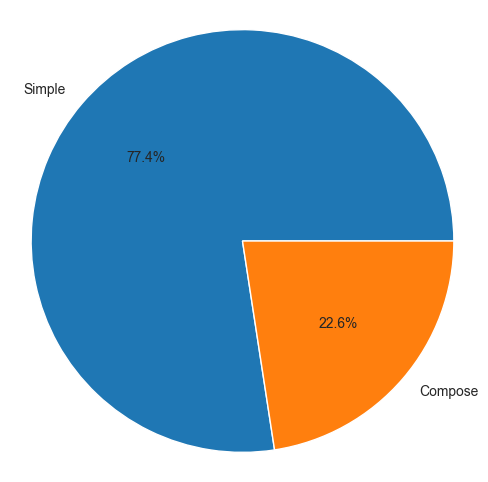

In [6]:
labels = ['Simple', 'Compose']
values = [
    len(df.query("identified_category == 'simple'")),
    len(df.query("identified_category == 'compose'"))
]

plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.axis("equal")

# save figures
plt.savefig("../assets/identified_category_distribution.png")
plt.savefig("../assets/identified_category_distribution.svg")

plt.show()

### Simple vs Compose by Province

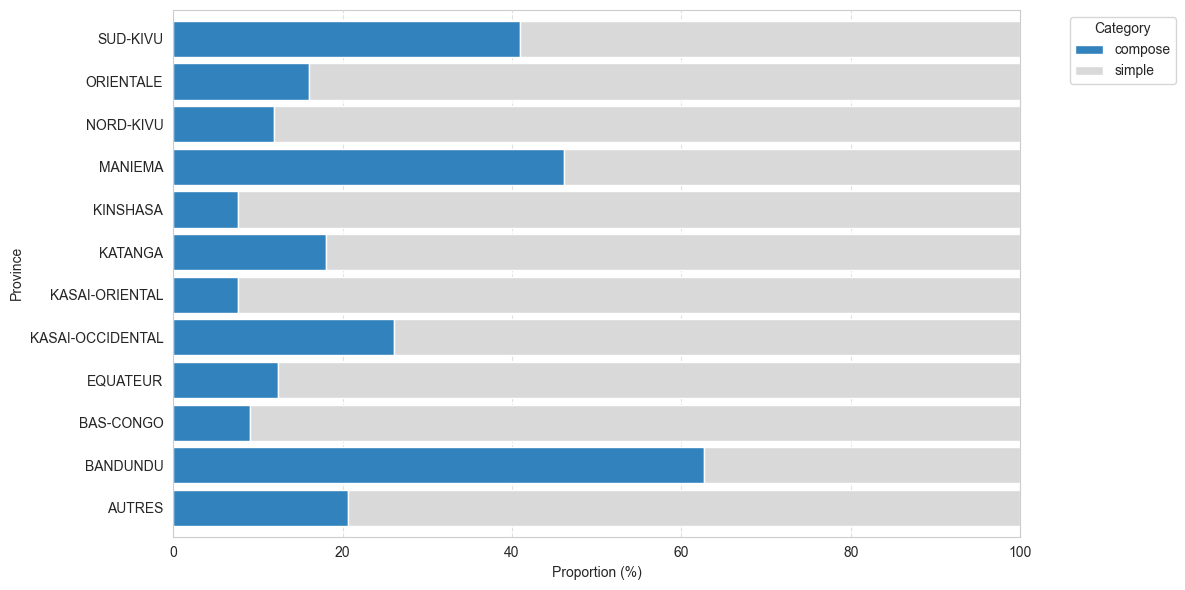

In [7]:
df_name_categories_pct = df_name_categories.div(df_name_categories.sum(axis=1), axis=0) * 100
ax = df_name_categories_pct.plot.barh(
    stacked=True,
    figsize=(12, 6),
    colormap="tab20c",
    width=0.85
)

ax.set_xlabel("Proportion (%)")
ax.set_ylabel("Province")
ax.set_xlim(0, 100)
ax.grid(axis="x", linestyle="--", alpha=0.6)

plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# save figures
plt.savefig("../assets/identified_category_distribution_by_province.png")
plt.savefig("../assets/identified_category_distribution_by_province.svg")

plt.show()

## Native Names vs Surnames

In [8]:
df_base = df.query("identified_category == 'simple'")

In [9]:
df_names = explode_words_token(df_base, 'identified_name', 'name')
df_names = df_names[['name', 'province', 'sex']].reset_index(drop=True)
df_names.describe().T

,count,unique,top,freq
name,10015595,644336,ilunga,82342
province,10015595,12,KINSHASA,2106077
sex,10015595,2,m,6033856


In [10]:
df_surnames = explode_words_token(df_base, 'identified_surname', 'name')
df_surnames = df_surnames[['name', 'province', 'sex']].reset_index(drop=True)
df_surnames.describe().T

,count,unique,top,freq
name,5007877,253743,jean,89564
province,5007877,12,KINSHASA,1053047
sex,5007877,2,m,3017009


### Transition probabilities

In [11]:
names_transitions = build_transition_probabilities(df_names['name'])
names_transitions_males   = build_transition_probabilities(df_names.query("sex == 'm'")['name'])
names_transitions_females = build_transition_probabilities(df_names.query("sex == 'f'")['name'])

names_transitions['df_probs'].to_csv("../assets/names_transition_probs.csv")

In [12]:
surnames_transitions = build_transition_probabilities(df_surnames['name'])
surnames_transitions_males = build_transition_probabilities(df_surnames.query("sex == 'm'")['name'])
surnames_transitions_females = build_transition_probabilities(df_surnames.query("sex == 'f'")['name'])

surnames_transitions['df_probs'].to_csv("../assets/surnames_transition_probs.csv")

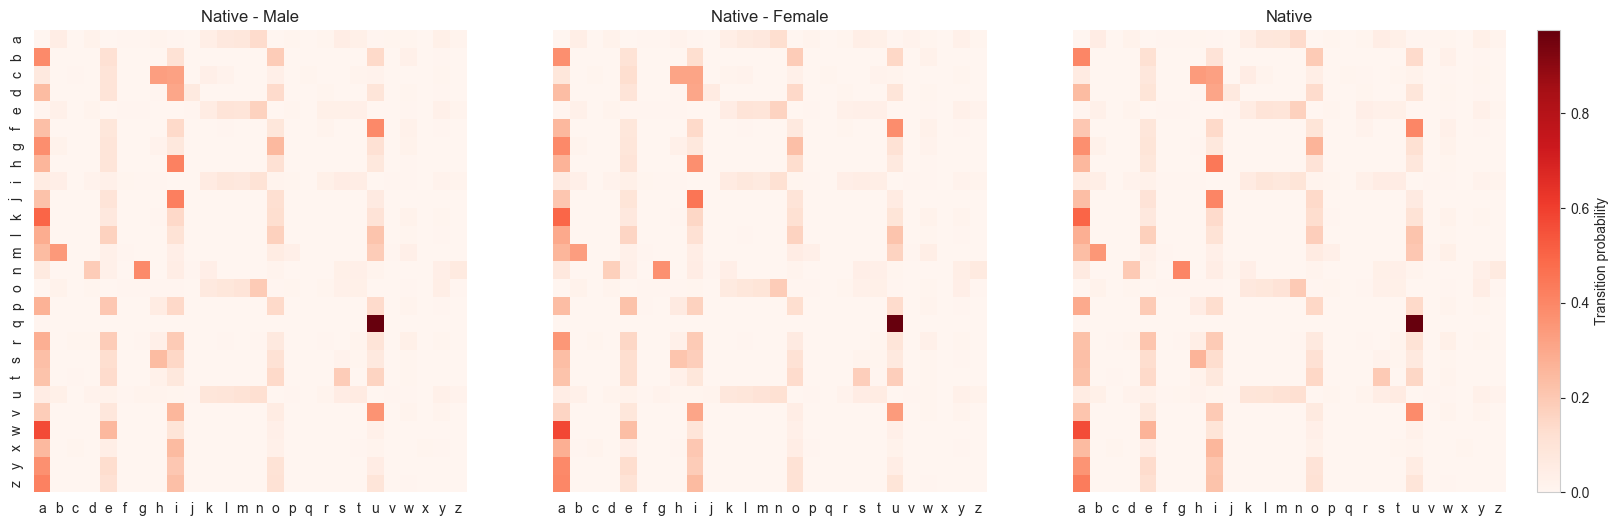

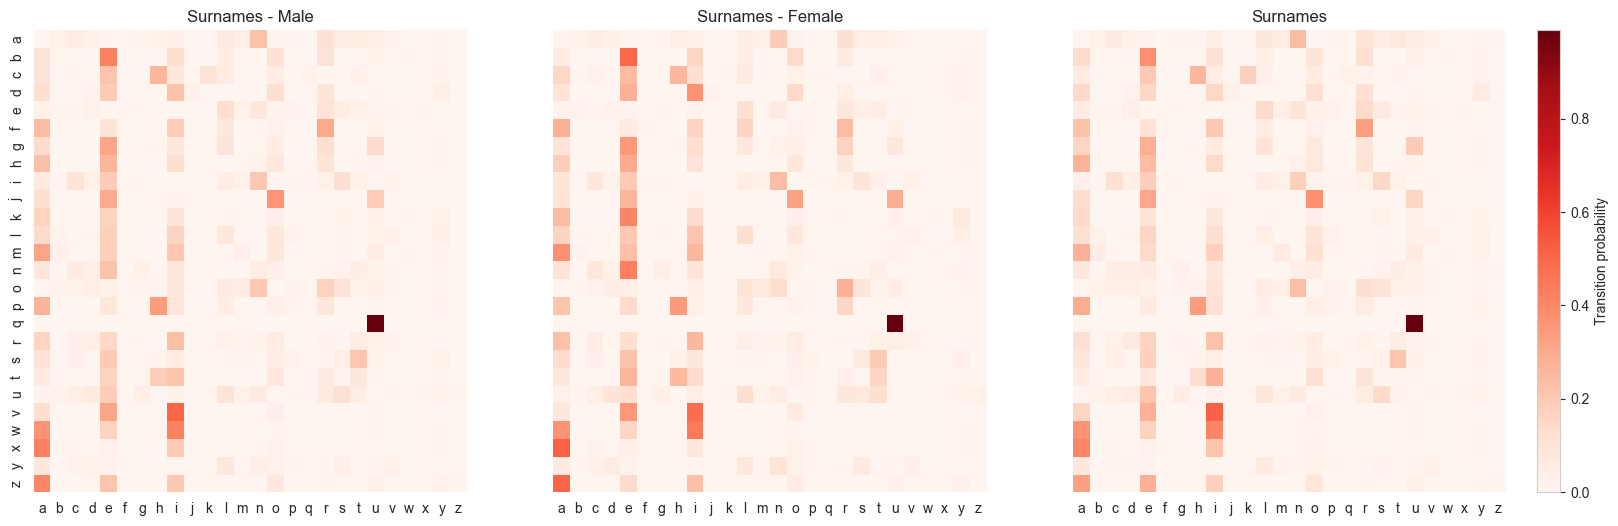

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)
hm1 = plot_transition_matrix(axes[0], names_transitions['df_probs'],   "Native - Male")
hm2 = plot_transition_matrix(axes[1], names_transitions_females['df_probs'], "Native - Female")
hm3 = plot_transition_matrix(axes[2], names_transitions_males['df_probs'],   "Native")
cbar = fig.colorbar(hm3.collections[0], ax=axes, orientation="vertical", fraction=0.03, pad=0.02)
cbar.set_label("Transition probability")
plt.savefig("../assets/names_transition_probabilities.png")
plt.savefig("../assets/names_transition_probabilities.svg")

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)
hm4 = plot_transition_matrix(axes[0], surnames_transitions['df_probs'],   "Surnames - Male")
hm5 = plot_transition_matrix(axes[1], surnames_transitions_females['df_probs'], "Surnames - Female")
hm6 = plot_transition_matrix(axes[2], surnames_transitions_males['df_probs'],   "Surnames")
cbar = fig.colorbar(hm6.collections[0], ax=axes, orientation="vertical", fraction=0.03, pad=0.02)
cbar.set_label("Transition probability")
plt.savefig("../assets/surnames_transition_probabilities.png")
plt.savefig("../assets/surnames_transition_probabilities.svg")
plt.show()

### Transition Probability Differences

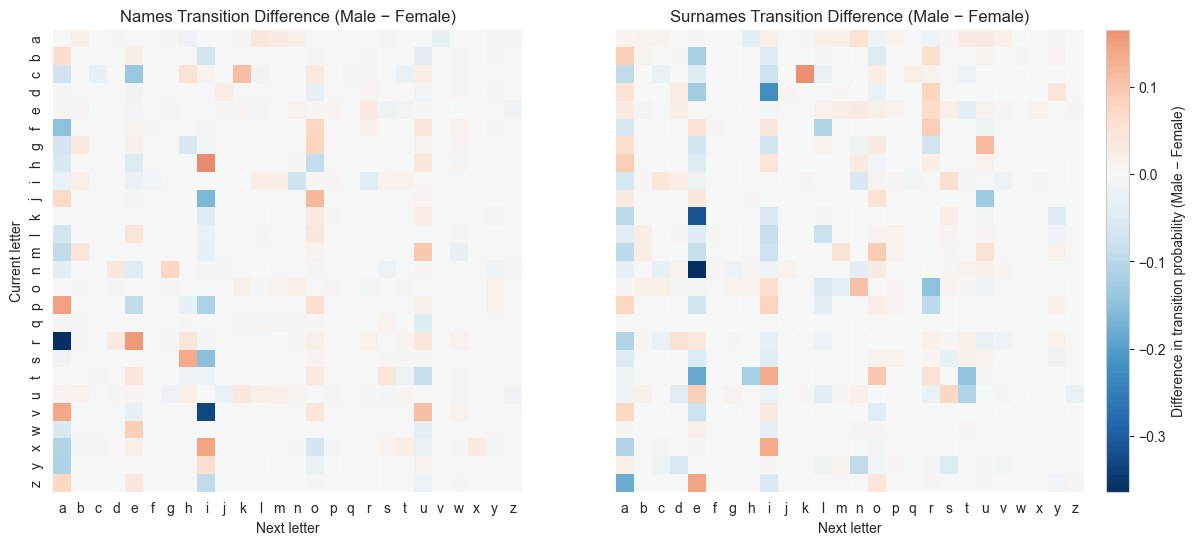

In [14]:
names_transitions_diff = names_transitions_males['df_probs'] - names_transitions_females['df_probs']
surnames_transitions_diff = surnames_transitions_males['df_probs'] - surnames_transitions_females['df_probs']

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

hm1 = sns.heatmap(names_transitions_diff.loc[list(LETTERS), list(LETTERS)], cmap="RdBu_r", center=0, ax=axes[0], cbar=False)
axes[0].set_title("Names Transition Difference (Male − Female)")
axes[0].set_xlabel("Next letter"); axes[0].set_ylabel("Current letter")

hm2 = sns.heatmap(surnames_transitions_diff.loc[list(LETTERS), list(LETTERS)], cmap="RdBu_r", center=0, ax=axes[1], cbar=False)
axes[1].set_title("Surnames Transition Difference (Male − Female)")
axes[1].set_xlabel("Next letter"); axes[1].set_ylabel("")

# Shared colorbar
cbar = fig.colorbar(hm2.collections[0], ax=axes, orientation="vertical", fraction=0.03, pad=0.02)
cbar.set_label("Difference in transition probability (Male − Female)")

plt.savefig("../assets/transition_difference.png")
plt.show()

In [15]:
df_comparisons = build_transition_comparisons(
    {
        'm': names_transitions_males,
        'f': names_transitions_females
    },
    {
        'm': surnames_transitions_males,
        'f': surnames_transitions_females
    }
)
df_comparisons.head(3)

,l2,kl_mf,kl_fm,jsd,permutation_p_value
names,0.318904,0.043201,0.021538,0.032370,0.979
surnames,1.277002,0.293619,0.239895,0.266757,0.001


l2 (Euclidean Distance): This metric shows the overall magnitude of the difference between the two matrices. The value for surnames (1.277) is significantly higher than for names (0.3189), indicating that the male and female surname transition matrices are farther apart than those for first names.

kl_mf and kl_fm (Kullback-Leibler Divergence): These values measure the information lost when one gender's probability distribution is used to approximate the other. The values for surnames (0.2936 and 0.2399) are much larger than for names (0.0432 and 0.0215). This reinforces the L2 distance's finding: there's a greater difference in the letter patterns between male and female surnames.

jsd (Jensen-Shannon Divergence): This is a symmetric, smoothed version of KL divergence. The jsd for surnames (0.2668) is much higher than for names (0.0324), providing a single, clear measure of the greater divergence in surname patterns.

The permutation_p_value is the most crucial part of this analysis. It determines whether the observed differences are statistically significant or likely due to random chance.

names (p-value = 0.979): A p-value of 0.979 is very high, far greater than the common significance level of 0.05. This means there's a 97.9% chance of observing a difference this large or larger even if there were no real difference in letter transition patterns between male and female first names. Therefore, you cannot reject the null hypothesis that the patterns are the same. The observed small difference (JSD = 0.032) is not statistically significant.

surnames (p-value = 0.001): A p-value of 0.001 is very low, well below the significance level of 0.05. This means there's only a 0.1% chance of observing a difference this large or larger if there were no real difference. This provides strong statistical evidence to reject the null hypothesis. The significant difference (JSD = 0.266) is not random; it indicates a genuine, statistically significant difference in the letter transition patterns between male and female surnames.

Conclusion: The analysis confirms that male and female surnames have distinct, gender-specific letter transition patterns, while the patterns in first names are not statistically different.

In [16]:
df_comparisons.to_csv("../assets/transition_comparisons.csv")

### Letters frequency

In [17]:
def plot_letter_grid(df_all: pd.DataFrame, use="freq", sort_values=False):
    """
    Plot a 1×3 grid of letter distributions for Male, Female, and Both.
    `use` ∈ {"freq","count"} controls y-axis.
    """
    # Slice datasets (adapt values if your labels are 'M'/'F', etc.)
    df_male   = df_all[df_all['sex'].str.lower() == str('m').lower()]
    df_female = df_all[df_all['sex'].str.lower() == str('f').lower()]

    L_m = build_letter_frequencies(df_male['name'])
    L_f = build_letter_frequencies(df_female['name'])

    y = "freq" if use == "freq" else "count"
    if sort_values:
        L_m = L_m.sort_values(y, ascending=False)
        L_f = L_f.sort_values(y, ascending=False)

    ymax = max(L_m[y].max(), L_f[y].max()) * 1.10

    fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharey=True, constrained_layout=True)
    for ax, data, title in zip(axes, [L_m, L_f], ["Male", "Female"]):
        ax.bar(data["letter"], data[y], color="steelblue", alpha=0.8)
        ax.set_title(title)
        ax.set_xlabel("Letter")
        ax.set_ylim(0, ymax)
        ax.grid(axis="y", alpha=0.3)
    axes[0].set_ylabel("Frequency" if y == "freq" else "Count")
    plt.show()

NameError: name 'pd' is not defined

In [19]:
plot_letter_grid(df_names, use="freq")

NameError: name 'plot_letter_grid' is not defined

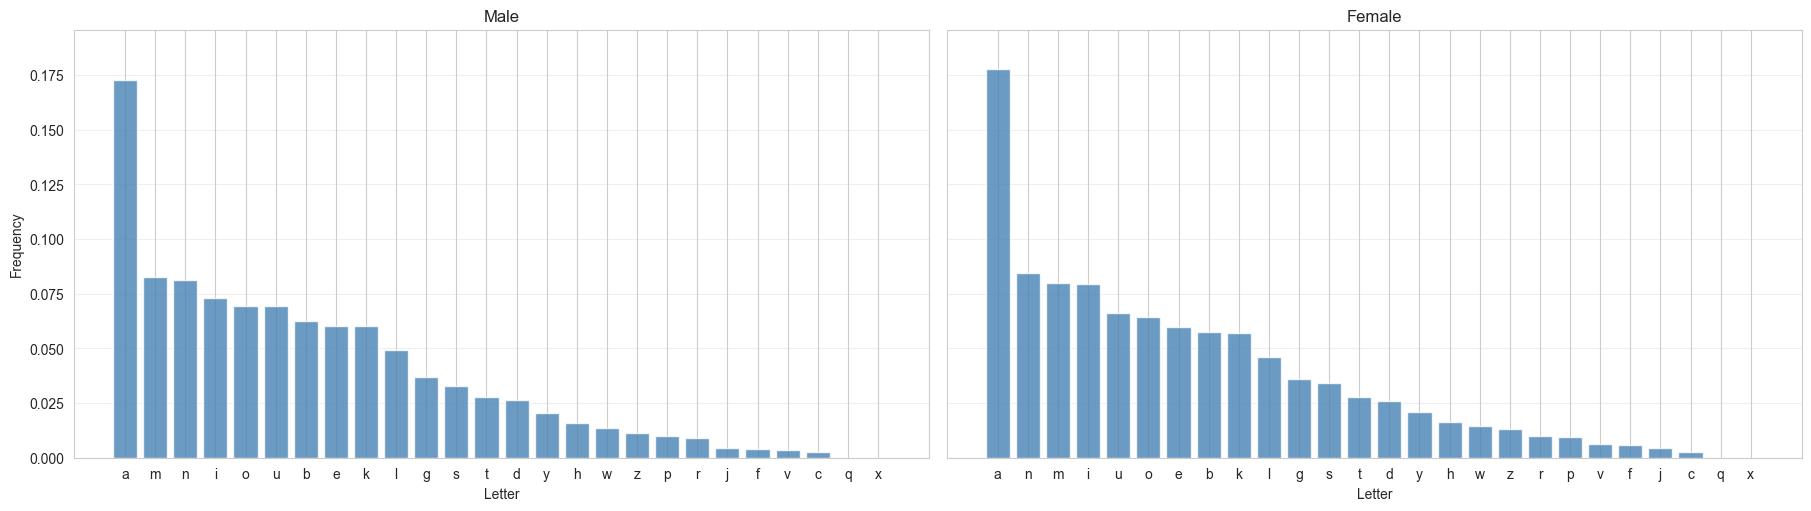

In [209]:
plot_letter_grid(df_names, use="freq", sort_values=True)

In [202]:
def count_ngrams(df: pd.DataFrame, n: int, col: str = "name") -> pd.DataFrame:
    # Normalize and clean
    _names = (
        df[col]
        .astype(str)
        .str.lower()
        .str.replace(r"[^a-z]", "", regex=True)
    )

    # Collect n-grams from all names
    ngrams = []
    for name in _names:
        if len(name) >= n:
            ngrams.extend(name[i:i+n] for i in range(len(name) - n + 1))

    # Count
    counter = Counter(ngrams)

    # Build DataFrame
    df_ngrams = (
        pd.DataFrame(counter.items(), columns=[f"{n}-gram", "count"])
        .sort_values("count", ascending=False)
        .reset_index(drop=True)
    )
    df_ngrams["freq"] = df_ngrams["count"] / df_ngrams["count"].sum()
    return df_ngrams

def plot_ngrams_grid(df: pd.DataFrame, n: int, top_k: int = 20,
                     gender_col="sex", male_value="m", female_value="f", name_col="name"):
    """
    Plot top n-grams for Male, Female, and All in a 1×3 grid.
    """
    # Split datasets
    df_male   = df[df[gender_col].str.lower() == str(male_value).lower()]
    df_female = df[df[gender_col].str.lower() == str(female_value).lower()]

    # Compute n-grams
    ng_male   = count_ngrams(df_male, n, col=name_col)
    ng_female = count_ngrams(df_female, n, col=name_col)

    # Plot in a grid
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True, constrained_layout=True)
    for ax, data, title in zip(
            axes, [ng_male, ng_female], ["Male", "Female"]
    ):
        sns.barplot(
            data=data.head(top_k),
            x=f"{n}-gram", y="count",
            ax=ax
        )
        ax.set_title(f"{title} – Top {top_k} {n}-grams")
        ax.set_xlabel(f"{n}-gram")
        ax.set_ylabel("Count")
        ax.tick_params(axis="x", rotation=45)

    plt.show()

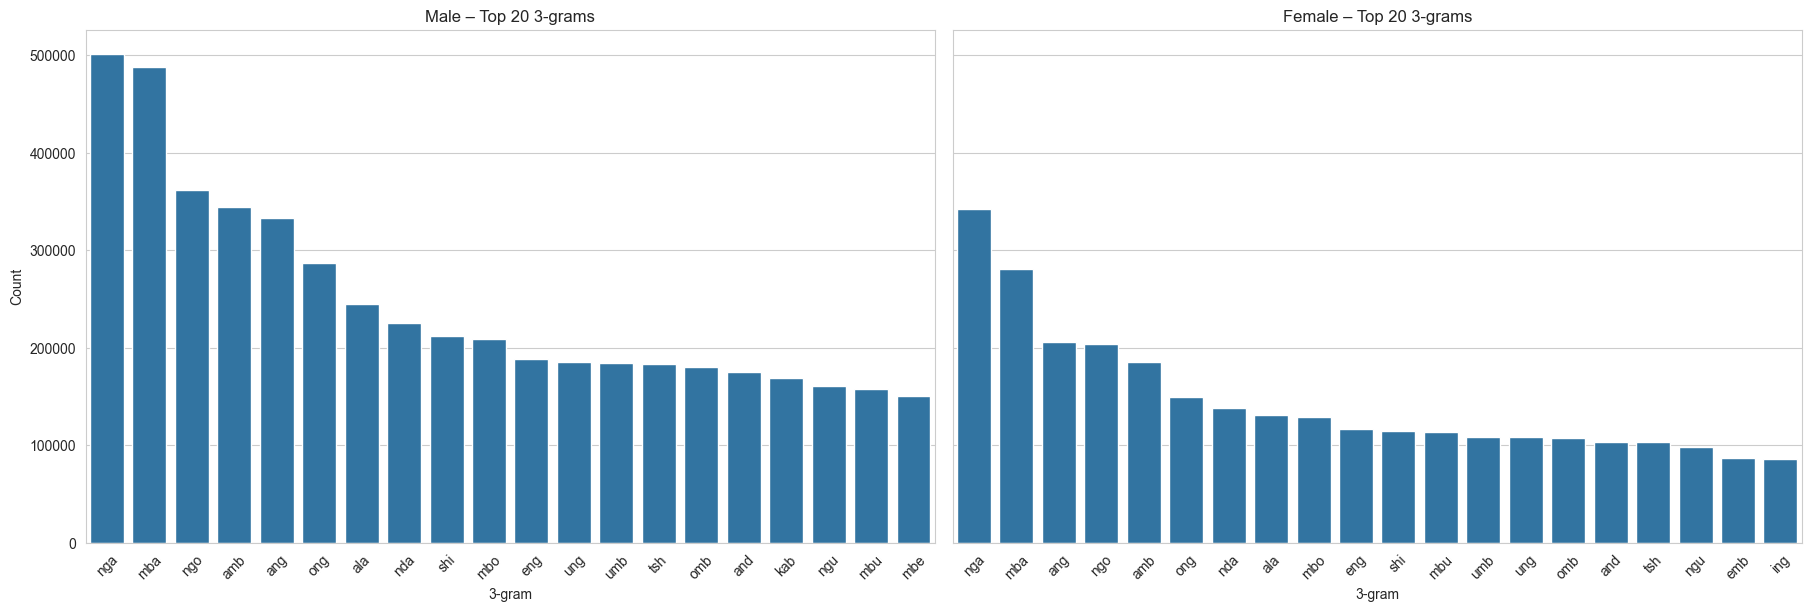

In [203]:
plot_ngrams_grid(df_names, n=3, top_k=20, gender_col="sex")

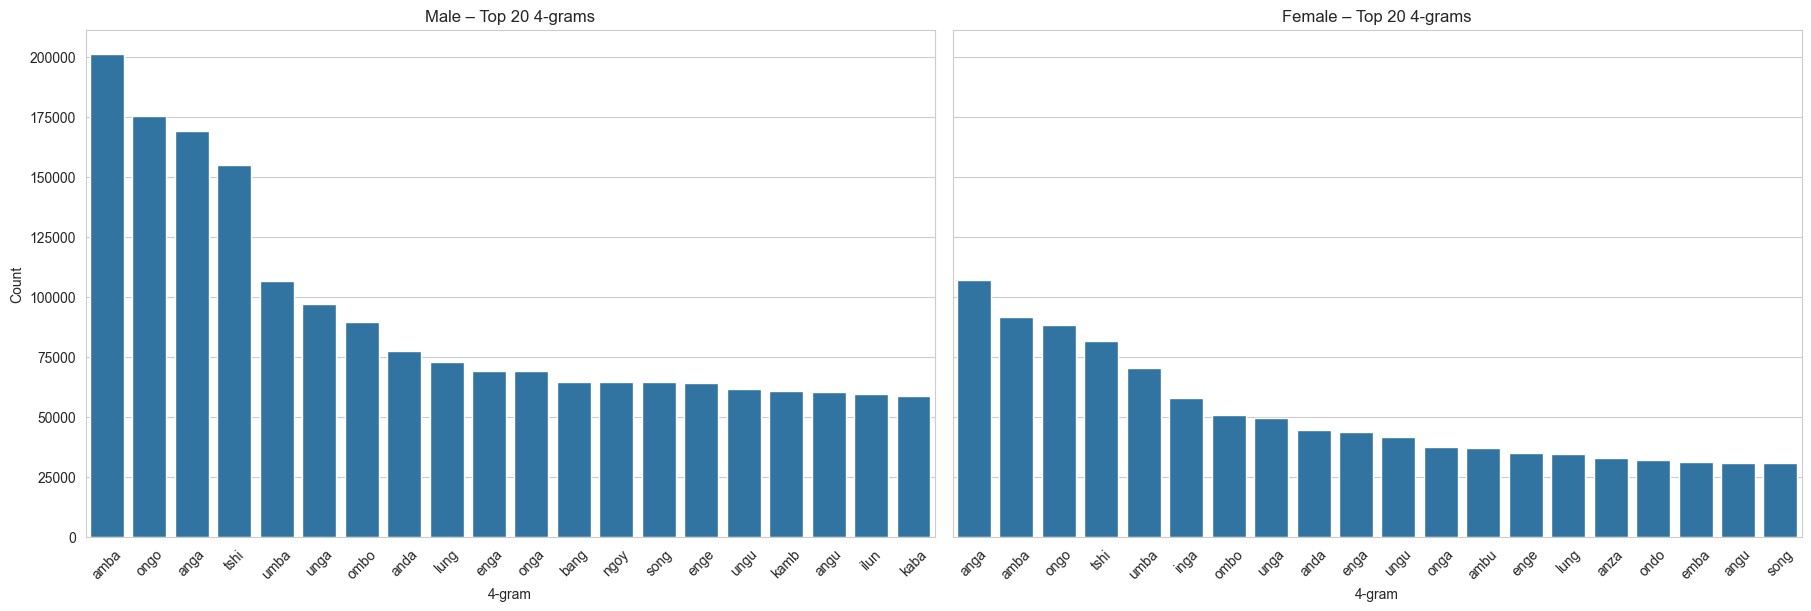

In [204]:
plot_ngrams_grid(df_names, n=4, top_k=20, gender_col="sex")

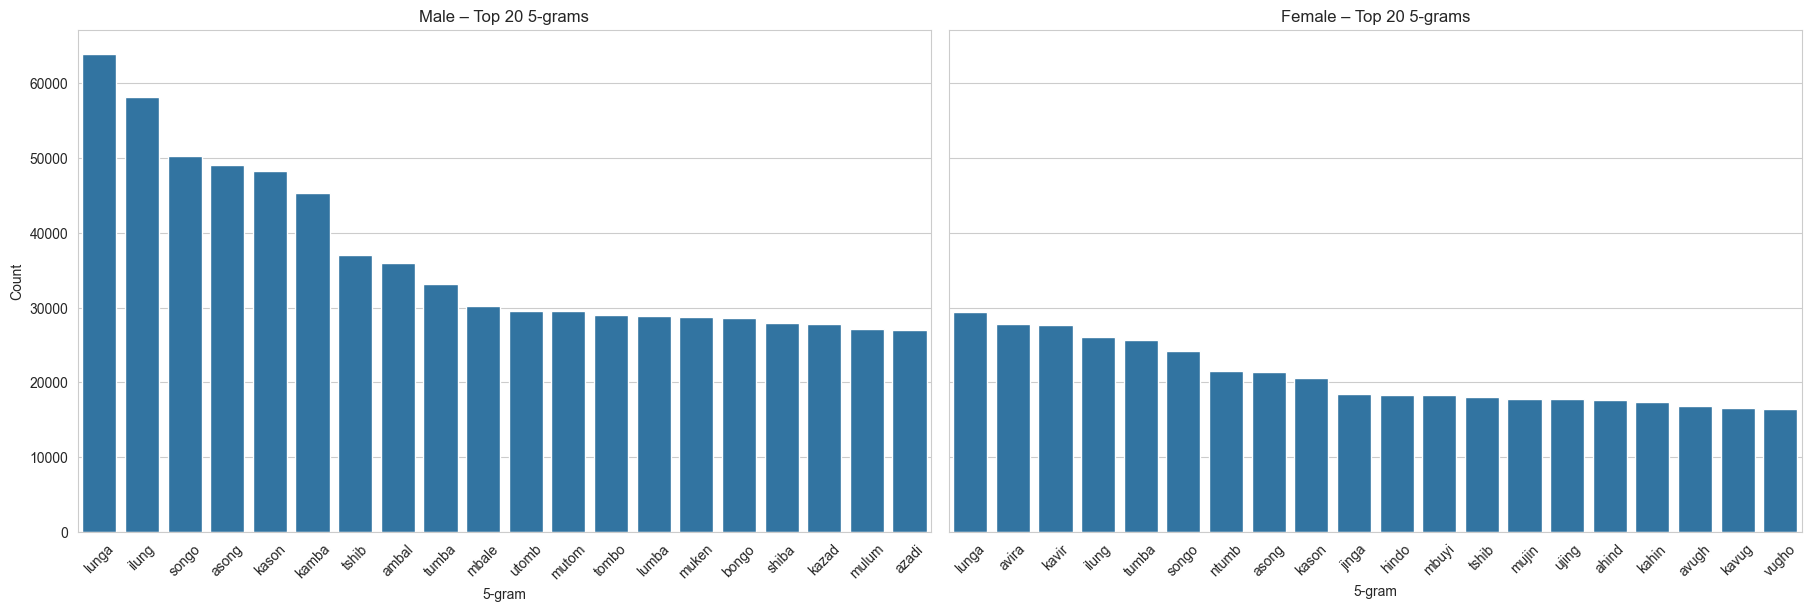

In [205]:
plot_ngrams_grid(df_names, n=5, top_k=20, gender_col="sex")

## Name generation

In [210]:
# tokens must include '^' (start) and '$' (end)
tokens = ["^"] + list(LETTERS) + ["$"]
token_to_idx = {t: i for i, t in enumerate(tokens)}
idx_to_token = np.array(tokens)
V = len(tokens)

# Prepare a well-formed probability matrix (rows sum to 1, no NaNs/negatives)
def prepare_prob_matrix(df_probs, tokens):
    import pandas as pd, numpy as np
    if isinstance(df_probs, pd.DataFrame):
        P = df_probs.loc[tokens, tokens].to_numpy(dtype=float, copy=True)
    else:
        P = np.array(df_probs, dtype=float, copy=True)
        if P.shape[0] != len(tokens) or P.shape[1] != len(tokens):
            raise ValueError(
                f"Matrix shape {P.shape} does not match tokens length {len(tokens)}. "
                "Use the same tokens used to build the matrix (e.g., transitions['tokens'])."
            )
    # clean & renormalize
    P[~np.isfinite(P) | (P < 0)] = 0.0
    rs = P.sum(axis=1, keepdims=True)
    P = np.divide(P, np.where(rs == 0, 1.0, rs), out=np.zeros_like(P), where=True)
    return P


def generate_name(P, token_to_idx, idx_to_token, *,
                  target_len=None,   # exact character length (letters only), if provided
                  min_len=1,         # minimum character length
                  max_len=12,        # hard cap on steps
                  temperature=1.0):
    start = token_to_idx['^']
    end   = token_to_idx['$']
    cur = start
    out = []

    for _ in range(max_len):
        row = P[cur]

        # Temperature scaling (τ<1 = sharper, τ>1 = flatter)
        if temperature != 1.0:
            row = np.power(row, 1.0 / temperature)
            s = row.sum()
            row = row / s if s > 0 else row

        row_mod = row.copy()

        # 1) Prevent early stop before min_len
        if len(out) < min_len:
            row_mod[end] = 0.0

        # 2) If target_len reached or exceeded, force end
        if target_len is not None and len(out) >= target_len:
            row_mod[:] = 0.0
            row_mod[end] = 1.0

        s = row_mod.sum()
        if s == 0.0:
            # Fallback: uniform over valid next tokens
            candidates = np.arange(V)
            # exclude '^'
            candidates = candidates[candidates != start]
            # exclude '$' if below min_len
            if len(out) < min_len:
                candidates = candidates[candidates != end]
            probs = np.ones(len(candidates)) / len(candidates)
            nxt_idx = np.random.choice(candidates, p=probs)
        else:
            row_mod = row_mod / s
            nxt_idx = np.random.choice(V, p=row_mod)

        if nxt_idx == end:
            break
        out.append(idx_to_token[nxt_idx])
        cur = nxt_idx

    return "".join(out).capitalize()

In [212]:
# Example preparation and usage
P = prepare_prob_matrix(transitions_male['df_probs'], tokens)
generated_var = [generate_name(P, token_to_idx, idx_to_token, min_len=5, max_len=12, temperature=0.5) for _ in range(10)]

names = pd.DataFrame(generated_var, columns=["name"])

In [213]:
names

,name
0,Tolemba
1,Kalanga
2,Mbayo
3,Kukasa
4,Kadamu
5,Bongalula
6,Kanga
7,Mangonga
8,Kayalela
9,Mbalo


In [216]:
P = prepare_prob_matrix(transitions_female['df_probs'], tokens)
generated_var = [generate_name(P, token_to_idx, idx_to_token, min_len=5, max_len=12, temperature=0.5) for _ in range(10)]

names = pd.DataFrame(generated_var, columns=["name"])

In [217]:
names

,name
0,Ngone
1,Kandi
2,Kangonga
3,Dangangandi
4,Kukale
5,Mando
6,Kasaba
7,Mambo
8,Mpolanga
9,Kangena
